# K-means inertia & silhouette score  

Throughout the following exercises, you will learn about the process of using inertia and silhouette score in scikit-learn to help determine a _k_ value for a K-means model on higher-dimensional data that cannot easily be visualized in 2-D or 3-D space.  Before starting on this programming exercise, we strongly recommend watching the video lecture and completing the IVQ for the associated topics.

In [22]:
#Import libraries 
import numpy as np 
import pandas as pd 

#libraries for modeling and evaluation 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

#To create synthetic data 
from sklearn.datasets import make_blobs

#Visualizing libraries
import seaborn as sns 
import matplotlib.pyplot as plt

**Create the data**

In practice, you'd have a dataset of real data, and you'd read in this data and perform EDA, data cleaning, and other manipulations to prepare it for modeling. For simplicity and to help us focus on the modeling itself, we're going to use synthetic data for this demonstration.

We'll start by creating a random number generator. This is to help with the process of creating reproducible synthetic data. We'll use it to create clustered data without us knowing how many clusters there are.

In [3]:
#create a random number generator 
rng = np.random.default_rng(seed= 44)
rng

Generator(PCG64) at 0x1CB4AC78900

In [5]:
#Create synthetic data with unknown number of clusters 
centers = rng.integers(low= 3, high= 7)
X,y = make_blobs(n_samples= 1000, n_features= 6, centers= centers, random_state=42)

The above steps that generated our synthetic data return two things: X and y. X is an array of the values for the synthetic data itself and y is an array that contains the cluster assignment for each sample in X (represented as an integer).

Right now we're concerned with X, because it is our mystery data. It's currently an array, but it's usually helpful to view your data as a pandas dataframe. This is often how your data will be organized when modeling real-world data, so we'll convert our data to a pandas df.

In [6]:
#create pandas dataframe from the above 
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5
0,-1.534288,5.467808,-6.945988,1.403934,1.553836,-7.618236
1,-6.681020,6.717808,2.764396,4.460744,-8.286569,10.959708
2,-8.678310,7.825306,3.139699,5.609951,-9.948079,8.072149
3,-6.667385,7.147637,2.145505,4.712937,-9.544708,11.093248
4,-2.753835,-4.209968,0.620345,-7.439505,-4.405723,-2.046149


We see that the data has 6 features (columns). This is too many for us to visualize in 2-D or 3-D space. We can't see how many clusters there are, so we'll need to use our detective skills to determine this.

## Scale the data

Since K-means uses distance between observations and centroids as its measure of similarity, it's important to scale your data before modeling, if it's not already scaled. It's important to scale because K-means doesn't know what your unit label is for each variable. Suppose you had data for penguins, and height were measured in meters and weight were measured in grams. Without scaling, significant differences in height would be represented as small numbers, while minor differences in weight would be represented as much larger numbers.

To perform scaling, we'll use scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#). StandardScaler scales each point xᵢ by subtracting the mean value for that feature and dividing by the standard deviation:

x-scaled = (xᵢ – mean(x)) / σ

This ensures that, after scaling, each feature variable has a mean of 0 and variance/standard deviation of 1. There are a number of scaling techniques available, including `StandardScaler`, `MinMaxScaler`, `Normalizer`, and others, each scaling the data in a particular way. There's no hard rule for determining which method will work best, but with K-means models, using any scaler will almost always result in better results than not scaling at all. 

You can instantiate StandardScaler and transform your data in a single step by using the `.fit_transform()` method and passing to it your data as an argument.

In [8]:
#Scale the data 
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-0.03173691,  0.4864719 , -1.32178135,  0.59808997,  1.5703227 ,
        -0.88951855],
       [-1.05006137,  0.68381835,  0.74465777,  1.2564266 , -0.97057774,
         1.92995522],
       [-1.44524212,  0.85866694,  0.82452504,  1.50392799, -1.39959784,
         1.49172609],
       ...,
       [-1.44108643,  0.57470676,  0.67179102,  1.05168791, -1.44319625,
         1.78196243],
       [ 0.07577944, -0.94372323,  0.61105458, -1.26945512,  0.20170316,
        -0.17403911],
       [ 0.0039502 , -1.36538025,  0.66658987, -0.78058848,  0.00272853,
        -0.24946726]])

## Instantiate the model

Now that the data is scaled, we can start modeling. Since we don't know how many clusters exist in the data, we'll begin by examining the inertia values for different values of k. 

One thing to note is that, by default, scikit-learn implements an optimized version of the K-means algorithm, called K-means++. This helps to ensure optimal model convergence by initializing centroids far away from each other. Because we're using K-means++, we will not rerun the model multiple times.

We'll begin by instantiating the model. If we want to build a model that clusters the data into three clusters, we'd set the `n_clusters` parameter to 3. We'll also set the `random_state` to an arbitrary number. This is only so others can reproduce your results. If you left this value blank, it's possible others could replicate your code exactly and still get different results due to the random initial placement of centroids.

In [10]:
# instantiate the model 
Kmeans3 = KMeans(n_clusters= 3, random_state= 42)

In [11]:
#Fit the model to data 
Kmeans3.fit(X_scaled)

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

This returns a model object that has "learned" your data. You can now call its different attributes to see inertia, location of centroids, and class labels, among others. See the [K-means documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) for a full list of available attributes.

We can get the cluster assignments by using the `.labels_` attribute. Similarly, we can get the inertia by using the `.inertia_` attribute. 

Let's see what happens when we check the cluster assignments and inertia for this model.

In [13]:
#get the label and inertia 
print('Clusters: ', Kmeans3.labels_)
print('inertia: ', Kmeans3.inertia_)

Clusters:  [2 0 0 0 1 1 1 0 0 2 1 0 0 2 0 0 0 0 1 1 1 0 0 0 2 2 1 0 0 1 1 0 1 1 2 2 1
 0 0 0 1 0 1 0 0 1 1 2 0 2 1 1 1 2 2 2 1 0 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1
 0 1 0 2 2 0 2 0 1 2 1 0 2 2 0 2 0 1 2 0 1 2 1 0 0 1 1 0 0 0 0 0 0 1 1 0 2
 1 0 1 0 0 1 1 2 1 1 1 0 1 1 0 0 1 2 0 2 2 2 1 0 2 2 1 0 1 1 1 0 2 2 2 1 1
 0 1 1 0 1 1 0 0 2 0 2 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 2 0 0 2 2 1 0 1 0 1
 0 2 0 2 0 1 1 1 0 0 0 2 2 0 1 0 0 1 0 1 1 1 1 1 2 1 2 0 0 1 2 2 0 1 1 2 1
 0 0 0 0 1 1 1 0 2 1 2 0 2 0 2 1 1 0 0 0 2 2 1 1 2 2 2 0 0 0 1 1 1 0 0 0 1
 0 1 2 1 0 0 2 2 1 1 0 1 2 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 2 1 0 1 2 2
 1 0 0 1 0 0 0 0 0 0 2 0 2 1 0 0 2 1 1 0 1 0 0 2 0 1 0 0 0 1 1 1 2 2 2 1 2
 2 2 0 0 2 0 2 1 0 1 2 0 2 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 2 0 0 0 0 0 1 1 2
 1 0 0 1 0 1 1 0 1 0 2 0 0 1 0 1 1 2 0 1 1 1 2 1 1 0 1 0 1 0 2 0 1 0 0 1 1
 2 0 1 1 2 1 1 0 0 0 0 1 0 1 0 0 2 2 1 2 1 1 1 0 0 2 1 0 0 0 1 0 1 0 2 0 1
 2 1 1 1 0 1 2 0 1 2 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 2 1 2 0 1 1 1 1 2 0
 0 1 0 0 2 2 0

The `.labels_` attribute returns a list of values that is the same length as the training data. Each value corresponds to the number of the cluster to which that point is assigned. Since our K-means model clustered the data into three clusters, the value assigned to each observation will be 0, 1, or 2. (Note that the cluster number itself is arbitrary, and serves only as a label.)  
<br/>

The `.inertia_` attribute returns the sum of the squared distances of samples from their closest cluster center.

In [18]:
#Calculate inertia from 2-11 clusters 
num_clusters = [i for i in range (2, 11)]

def kmeans_inertia(num_clusters, x_vals):
    inertia= []
    for num in num_clusters:
        kms= KMeans(n_clusters= num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    return inertia

In [20]:
#Calculate inertia for k=2-10
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia 

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

[3090.326034846853,
 1748.148870307951,
 863.1663243212964,
 239.6543475871844,
 231.15033338571047,
 221.5241540929842,
 214.87497278782968,
 206.29676151470233,
 199.85993193411025]

### Elbow plot

Now we can plot these values in a simple line graph, with the _k_ values along the x-axis and inertia on the y-axis. This type of plot is called an elbow plot. The "elbow" is usually the part of the curve with the sharpest angle, where the reduction in inertia that occurs when a new cluster is added begins to level off. 

Text(0, 0.5, 'Inertia values')

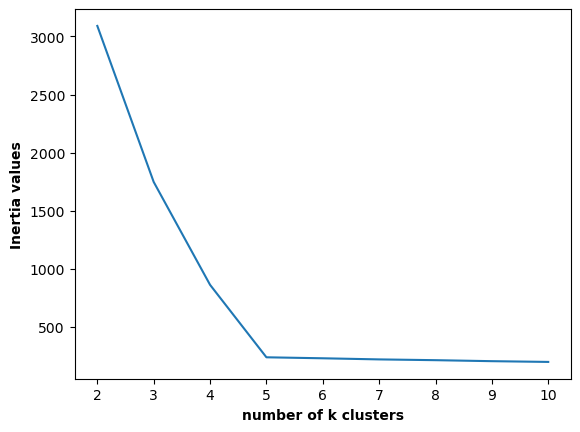

In [24]:
#plot the elbow 
sns.lineplot(x=num_clusters, y= inertia)
plt.xlabel('number of k clusters', weight= 'bold')
plt.ylabel('Inertia values', weight= 'bold')


This plot contains an unambiguous elbow at five clusters. Models with more than five clusters don't seem to reduce inertia much at all. Right now, it seems like a 5-cluster model might be optimal.

Let's now check silhouette scores. Hopefully the results will corroborate our findings from the assessment of inertia.

In [27]:
#get the silhouette score for kmeans3
Kmeans3_sil_score = silhouette_score(X_scaled, Kmeans3.labels_)
Kmeans3_sil_score

0.5815196371994132

In [31]:
#now we compare the score with other K clusters 
def kmeans_sil(num_clusters, x_vals):
    sil_score= []
    for num in num_clusters:
        kms = KMeans(n_clusters= num, random_state= 42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))
    return sil_score


In [32]:
#Calculate the score for K 2-10 
sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

[0.4792051309087745,
 0.5815196371994132,
 0.6754359269330664,
 0.7670656870960783,
 0.6386298233446862,
 0.5255232814143497,
 0.4075837029239973,
 0.27954043923384386,
 0.14988364343771404]

Text(0.5, 1.0, 'elbow graph for number of K values')

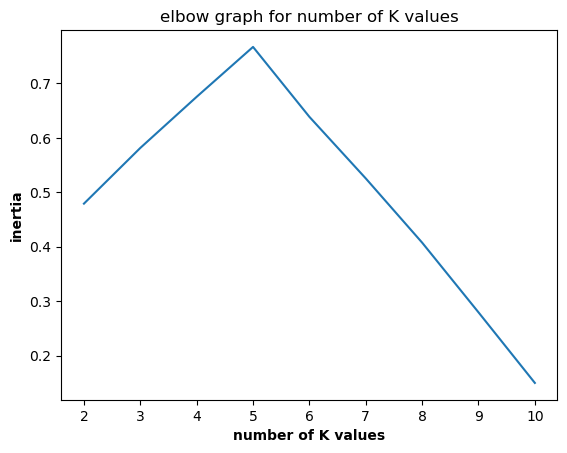

In [36]:
#plot the elbow graph 
sns.lineplot(x= num_clusters, y=sil_score)
plt.xlabel('number of K values', weight= 'bold')
plt.ylabel('inertia', weight= 'bold')
plt.title('elbow graph for number of K values')

## Conclusion

At this point, between our inertia and silhouette score analyses, we can say with a reasonable degree of confidence that it makes the most sense to group our data into five clusters. 
<br/>  
Since we used synthetic data for this activity, we can cheat and check to see how many clusters _actually_ existed in our data. We can do this by calling the `centers` variable, which we created with the random number generator at the beginning of this notebook.

In [37]:
# Verify our findings (only possible when "correct" number of clusters exists)
centers

5

## Further analysis

Although we know that five clusters is the best grouping for the data, the work is far from done. At this point, we'll instantiate a new K-means model with `n_clusters=5` and fit it to our data. (Note that if we had saved all the models that we fit above for different values of _k_, we wouldn't need to refit a model now, we could just call that model from earlier. But since it wasn't saved, we must fit another model.)

In [38]:
#Fit a 5 clusters model to the data 
kmeans5 = KMeans(n_clusters= 5, random_state=42)
kmeans5.fit(X_scaled)

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

In [41]:
#Check clusters k unique values 
print('K unique values: ', np.unique(kmeans5.labels_))

K unique values:  [0 1 2 3 4]


In [44]:
#Assign a new column to see the clusters 
X['clusters'] = kmeans5.labels_
X.head()

,0,1,2,3,4,5,clusters
0,-1.534288,5.467808,-6.945988,1.403934,1.553836,-7.618236,2
1,-6.681020,6.717808,2.764396,4.460744,-8.286569,10.959708,4
2,-8.678310,7.825306,3.139699,5.609951,-9.948079,8.072149,4
3,-6.667385,7.147637,2.145505,4.712937,-9.544708,11.093248,4
4,-2.753835,-4.209968,0.620345,-7.439505,-4.405723,-2.046149,1
